# Predicting Reservoir Storage

## Introduction

California has one of the most complex water systems in the world. With a population of nearly 40 million residents and the largest agricultural economy of any state, water management has become key to keeping the state running. However, the state has faced increasing water uncertainty as climate change destabilizes annual rainfall and increases temperatures. Droughts have also increased and intensified. The snowpack and its spring melt has shrank significantly in the past 2 decades, causing water shortages.

Predicting water storage has been a key goal for California policymakers to determine allocations to farmers, municipalities, and industry, as well as environmental objectives such as maintaining fish populations. While California's policymakers and researchers have come up with prediction bencharks, machine-learning approaches have not been used before. This novel style could allow for future research.



## Project Summary

My project's goal is to model and predic reservoir water levels in California. Using a previous years temperature and precipitation data, I hoped to see how accurately I could predict reservoir capacity and provide a range of possible values, not given the current water year data.

This project is of utmost importance given California's intensifying climate crisis. For my process of data analysis and model training, I use Folsom Lake, the 10th largest dam in California and a key water supply for millions of its residents. For personal context, I grew up in Sacramento by Folsom Lake. It is going increasingly deep in its reserves during the extending droughts, having got to as low as 14% of its capacity in 2014. 

My goal was to create a model that could use exogenous seasonal variables to predict seasonal water supply and its annual minimum. Once I trained and tested on Folsom Lake, I would be able to expand and test the model on other Sacramento River watershed reservoirs and then work south on San Joaquin River watersheds. With these models trained on older data, I can predict on the 2021 water year, which ended this September 30th.

Time series models that made the most sense for this were seasonal, stationary and auto-regressive. I performed a gridsearch to find the best paramters for SARIMS and compaed it to a naive model, which assumes that the water level will be the exct same a year ago as water levels are a yearly cycle. I then add in exogenous variables and compare this with the solely endogenous SARIMA model.

I found that a SARIMA model was best able to pick up on the drought patterns of California to provide accurate year-out forecasts. In fact, the exogenous-input based SARIMAX was exclusively weaker.

### Methodology

I read through the latest literature, some of which is cited in the References section for inspiration on approaches. ***

In [1]:
#import libraries
! pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import auto_arima, decompose

from functools import reduce
import itertools

## Data Understanding

To predict Folsom Lake's water storage, we can take daily data from the US Bureau of Reclamation. The bureau has extensive time series datasets going back into vthe early 1900's on most major reseroirs in the country, There is also an exogenous variable of interest which could help in predictions: the daily evaporation is available for each reservoir. Other variables I could pull from the site include daily release, precipitation, inflow, and water level by height; however, I decided to go with other sources for weather data.


While some of the originl datasets are daily, my computer does not have the capacity to handle the computations for 365 period of seasonal data. So we grouped up data into monthly chunks.

In [2]:
storage = pd.read_csv('data/folsomlake/folsom_storage.csv',header=7) #acre feet
evaporation = pd.read_csv('data/folsomlake/folsom_evaporation.csv',header=7) #sum cfs 24 hr


In [3]:
#examine Folsom Lake data
print(storage.head())
print(evaporation.head())

                         Location               Parameter  Result Units  \
0  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  569846    af   
1  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  568275    af   
2  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  566879    af   
3  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  564963    af   
4  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  562713    af   

  Timestep Aggregation       Datetime (UTC)  
0    daily     instant  1989-10-01 08:00:00  
1    daily     instant  1989-10-02 08:00:00  
2    daily     instant  1989-10-03 08:00:00  
3    daily     instant  1989-10-04 08:00:00  
4    daily     instant  1989-10-05 08:00:00  
                         Location                   Parameter  Result Units  \
0  Folsom Lake Dam and Powerplant  Lake/Reservoir Evaporation   42.23   cfs   
1  Folsom Lake Dam and Powerplant  Lake/Reservoir Evaporation   42.17   cfs   
2  Folsom Lake Dam and Powerplant  L

Because rain and temperature conditions are a key part of predicting watershed health and droughts (https://www.usgs.gov/special-topic/water-science-school/science/droughts-things-know?qt-science_center_objects=0#qt-science_center_objects), I decided to incorporate comprehensive data that could cover the true health of the watersheds each season. 

The California Data Exchange Center has time series data provided by the California Department of Water resources. I chose two datasets for precipitation levels.

The 8-station Sierra Index tracks precipitation across the Northern Sierras, and is an accurate measure of the water coming into the Sacramento River watershed. The Sacramento River watershed is the largest watershed in California, and contains many of the key reservoirs we will be modelling.

Meanwhile, the 5-station Sierra Index tracks precipitation in the Southern Sierras, and is a measure of the water year of the San Joaquin River watershed, the second largest watershed in the state.

I downloaded these to utilize as an exogenous variable. Both datasets are monthly. 

Please see the readme for more information on how to reproduce this data.

Sources:
http://cdec4gov.water.ca.gov/dynamicapp/QueryWY?Stations=8SI&SensorNums=2&End=2021-12-05&span=35
http://cdec4gov.water.ca.gov/dynamicapp/QueryWY?Stations=5SI&SensorNums=2&End=2021-12-05&span=35

In [4]:
northsierra = pd.read_csv('data/8SI.csv')
southsierra = pd.read_csv('data/5SI.csv')

In [5]:
print(northsierra.head())
print(southsierra.head())

   Unnamed: 0  Monthly  Annual
0  1989-10-31     6.29   35.97
1  1989-11-30     3.08   35.97
2  1989-12-31     0.07   35.97
3  1990-01-31     7.88   35.97
4  1990-02-28     4.60   35.97
  STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE  DATE TIME  OBS DATE  VALUE  \
0        5SI        M              2      RAIN        NaN  19881001   0.03   
1        5SI        M              2      RAIN        NaN  19881101   6.16   
2        5SI        M              2      RAIN        NaN  19881201   5.58   
3        5SI        M              2      RAIN        NaN  19890101   1.48   
4        5SI        M              2      RAIN        NaN  19890201   3.49   

   ANNUAL DATA_FLAG   UNITS  
0   32.89       NaN  INCHES  
1   32.89       NaN  INCHES  
2   32.89       NaN  INCHES  
3   32.89       NaN  INCHES  
4   32.89       NaN  INCHES  


### Data Preprocessing

I edited the dataframes so they can be interpreted as time series and have matching start and end dates is crucial to our modelling. As water years begin October 1st each year, we will starting in October 1st 1989, the beginning of the 1990 water year, and ending September 30th 2021, the end of the 2021 water year.

In [6]:
#drop unnecessary columns

drop_list = ['Location','Parameter','Timestep','Aggregation','Units']

storage.drop(drop_list,axis=1,inplace=True)
evaporation.drop(drop_list,axis=1,inplace=True)

#rename for clarity
storage.rename(columns= {'Result': 'storage'},inplace=True)
evaporation.rename(columns= {'Result': 'evaporation'},inplace=True)

In [7]:
#adjust dates to water year
start_date = "1989-10-01"
end_date = "2021-10-01"

storage = storage[(storage['Datetime (UTC)'] >= start_date) & (storage['Datetime (UTC)'] <= end_date)]

evaporation = evaporation[(evaporation['Datetime (UTC)'] >= start_date) & (evaporation['Datetime (UTC)'] <= end_date)]

#rename columns
storage['date']= pd.to_datetime(storage['Datetime (UTC)']).dt.date
evaporation['date']= pd.to_datetime(evaporation['Datetime (UTC)']).dt.date
storage.drop('Datetime (UTC)',axis=1,inplace=True)
evaporation.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
storage.set_index('date',inplace=True)
evaporation.set_index('date',inplace=True)

#set index to datetime format

storage.index = pd.to_datetime(storage.index)
evaporation.index = pd.to_datetime(evaporation.index)

In [8]:
#convert north sierra and south sierra indices to time series data
northsierra.rename({'Unnamed: 0':'date'},axis=1,inplace=True)
northsierra['date'] = pd.to_datetime(northsierra['date'])
northsierra.set_index('date',inplace=True)

#clean south sierra set to just the necessary info
drop_list = ['STATION_ID','DURATION','SENSOR_NUMBER','SENS_TYPE','DATE TIME','DATA_FLAG','UNITS']
southsierra.drop(drop_list,axis=1,inplace=True)

southsierra['OBS DATE'] = southsierra['OBS DATE'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

southsierra = southsierra[(southsierra['OBS DATE'] >= start_date) & (southsierra['OBS DATE'] <= end_date)]


southsierra.rename({'OBS DATE':'date'},axis=1,inplace=True)
southsierra.set_index('date',inplace=True)

The time series machine learning models will struggle to handle the number of time periods if we do not aggregrate up from daily data, so I did that below.

In [9]:
#aggregate data to monthly

storage = storage.resample('1M').mean().round(2)
evaporation = evaporation.resample('1M').mean().round(2)

southsierra = southsierra.resample('1M').sum().round(2)
northsierra = northsierra.resample('1M').sum().round(2)

In [10]:
#drop unneeded extra rows

northsierra.drop([pd.to_datetime('2021-10-31'),pd.to_datetime('2021-11-30')],inplace=True)
southsierra.drop(pd.to_datetime('2021-10-31'),inplace=True)

Since Folsom Lake is a part of the Sacramento Valley watershed, we are going to do a merge on the storage and evaporation datasets with the northern sierra precipitation dataset.

In [11]:
df_list = [northsierra ,evaporation,storage]

data = reduce(lambda left,right: pd.merge(left,right,on=['date'],how='outer'),df_list)

data

,Monthly,Annual,evaporation,storage
date,,,,
1989-10-31,6.29,35.97,35.90,502846.52
1989-11-30,3.08,35.97,15.41,384687.83
1989-12-31,0.07,35.97,7.85,334015.23
1990-01-31,7.88,35.97,9.24,327160.32
1990-02-28,4.60,35.97,12.39,352706.71
...,...,...,...,...
2021-05-31,0.18,23.20,67.03,366416.48
2021-06-30,0.08,23.20,73.73,328650.80
2021-07-31,0.08,23.20,59.77,262166.35


# Exploratory Data Analysis
The majority of our analysis centers around storage, the target variable. We notice how the data variance rapidly shifted from the 1990's onwards. This makes sense as California's climate has increasingly destabilized, resulting in more need for reservoir water.

### Plotting the target and exogenous variables

An important note for all the below graphs is that the tick marks correspond to actual years, not water years. So a tick mark of 2015 is January 1st 2015, not October 1st 2014.

As seen in the storage data below, water storage peaks during the spring melt and troughs before the rain season begins in November.

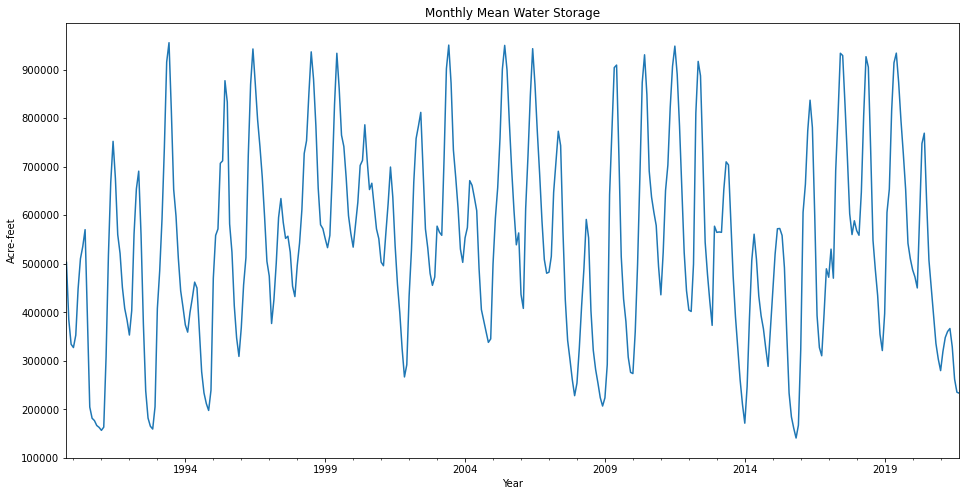

In [12]:
data.storage.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Monthly Mean Water Storage')
plt.show();

Below, we can see that evaporation is high in the summers, especially in heat waves, and drops to near nothing in the winters. This is valuable for predicting water storage given its correlation to temperature nd its sizeable impact on reservoir levels.

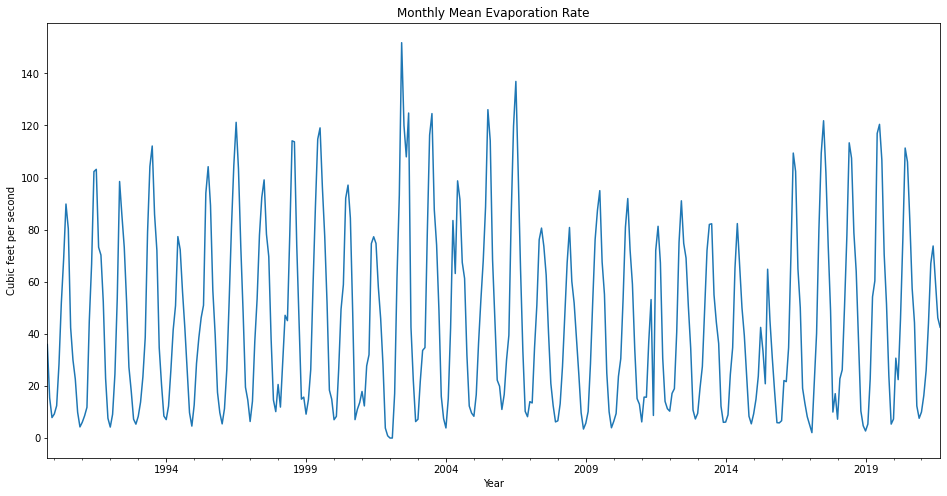

In [13]:
#plot average cfs evaporation per month

data.evaporation.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Cubic feet per second')
plt.title('Monthly Mean Evaporation Rate')
plt.show();

Below, we see how increasingly variable annual rainfall is. We can see its correlation to reservoir levels especially in the past couple years, 2019-2021, when a new drought began. The above reservoir storage also bottoms and doesn't recover.

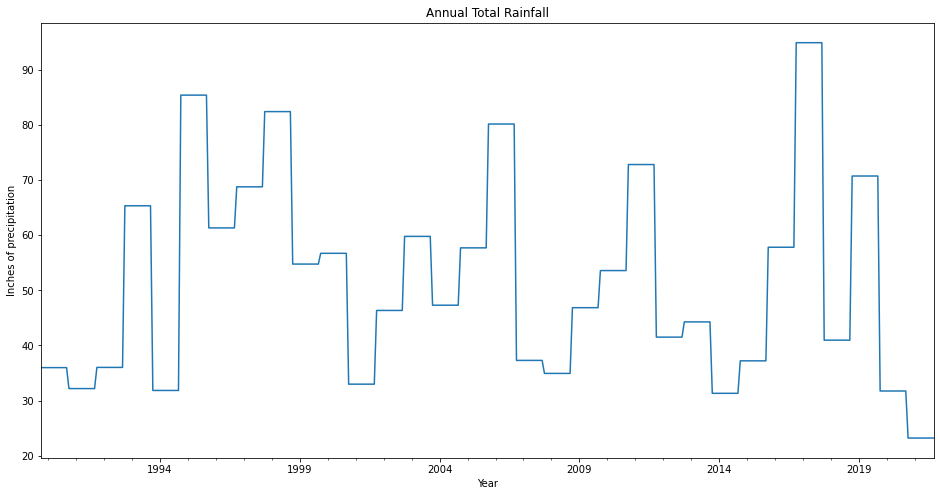

In [14]:
#plot annual rainfall

data.Annual.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Inches of precipitation')
plt.title('Annual Total Rainfall')
plt.show();

The below graph demonstrates the variability of California's climate but also affirms how important the winter rainfall season is. While varying in start date, winter is always the most time of rainfall.

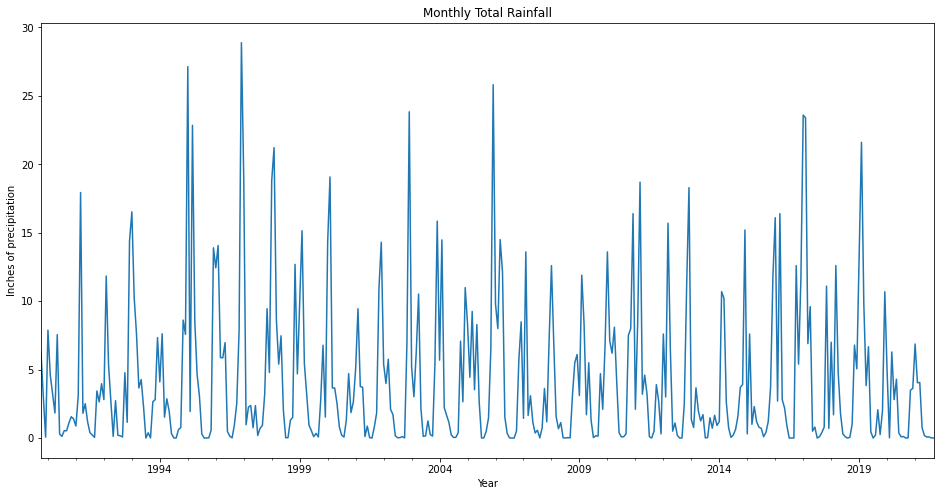

In [15]:
#plot monthly rainfall

data.Monthly.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Inches of precipitation')
plt.title('Monthly Total Rainfall')
plt.show();

### Examining the target's autocorrelation

Below, we see the strong seasonal correlation every 12 months. This correlation is significant even decades after measurement, shown by the fact the curve goes above the dotted line even past 250 months.

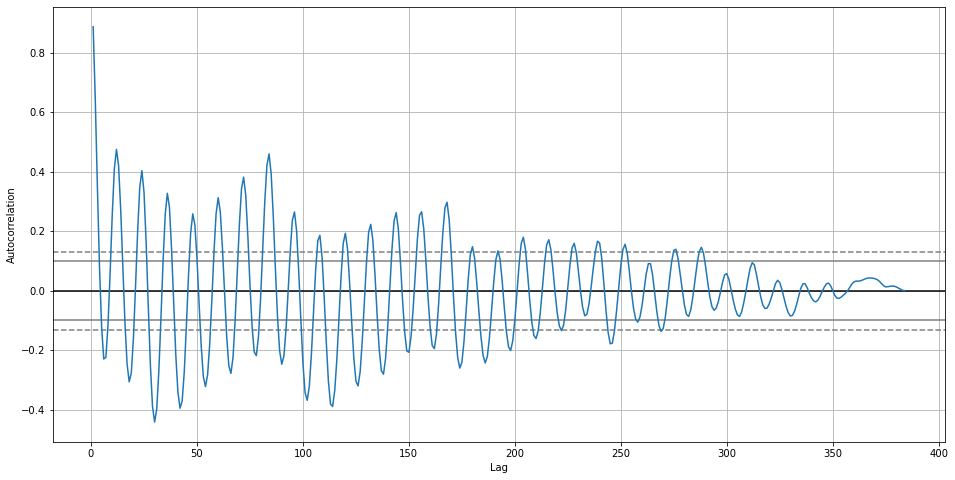

In [16]:
fig, ax1 = plt.subplots(figsize = (16,8))

pd.plotting.autocorrelation_plot(data['storage'],ax=ax1)
plt.show();

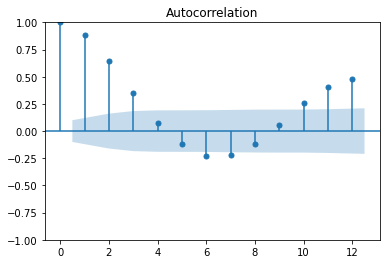

In [17]:
plot_acf(data['storage'],lags=12);

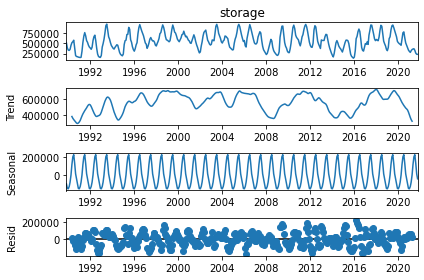

In [18]:
result = seasonal_decompose(pd.Series(data['storage']),model='additive', period=12)

result.plot()
plt.show();

The two lag plots below confirm that there is a positively linear correlation between the storage data a month and a year after. The y+1 is much stronger than the y+12.

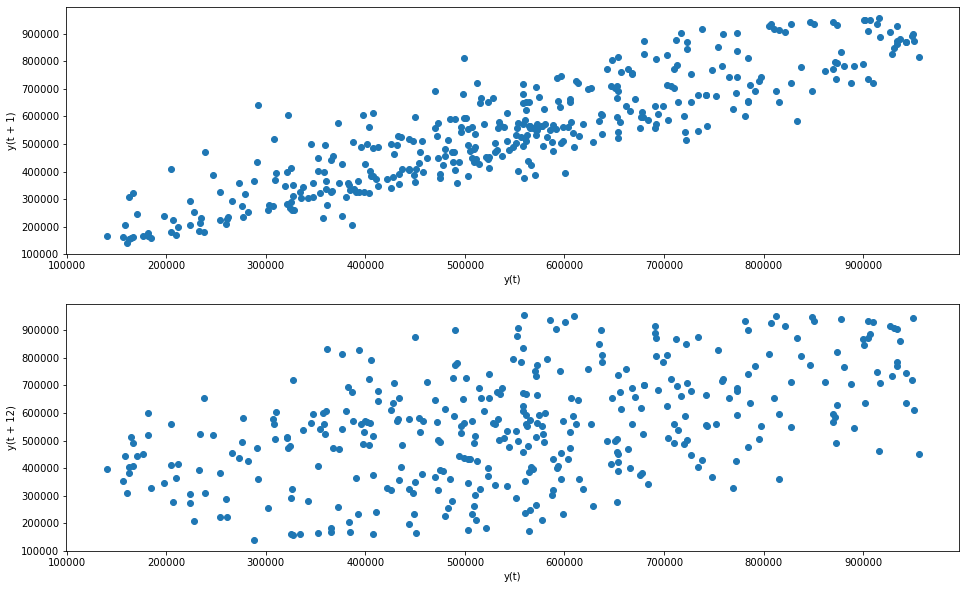

In [19]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
pd.plotting.lag_plot(data['storage'],ax=ax1,lag=1)
pd.plotting.lag_plot(data['storage'],ax=ax2,lag=12)
plt.show();

## Testing for Stationarity

For modelling to be accurate, we need to test for stationarity. We will do this using the Augmented Dickey Fuller Test. The null hypothesis is that the data is non-stationary. 

In [20]:
result = adfuller(data['storage'])
result


(-4.429086309898389,
 0.0002635588358342595,
 12,
 371,
 {'1%': -3.4480996560263386,
  '5%': -2.8693621113224137,
  '10%': -2.570937038891028},
 9116.56569503065)

Because the p-value is .0007, we can confidently reject the null hypothesis. The data is therefore stationary.

# Modelling
Our goal is to find a model that can most accurately predict the 2020 water year reservoir storage based on past years data. To recap, water years run from October 1st to September 30th each year. We will test the value of using exogenous variables versus using an autoregressive, seasonal, and moving average model. 

As hinted above, I initially tried running a SARIMA model on daily data; but having 365 periods of data to run through per season was too computationally expensive. Thus we run all models like our data is, with 12 periods per season. 

## Creating the Train and Test Sets

To be able to make year ahead predictions, we can only use data from the past water year. So I must roll the exogenous variables forward so each water year's predictions are calculated on the past. This will make the 1990 water season not usable for the dataset when using exogenous variables, given we don't have 1989 WY data.

In [21]:
#roll exogenous variables 1 season behind
df = data.copy()

df['Last_Monthly_Prcp'] = data['Monthly'].shift(12)
df.drop('Monthly',axis=1,inplace=True)
df['Last_Annual_Prcp'] = data['Annual'].shift(12)
df.drop('Annual',axis=1,inplace=True)

df['Last_Monthly_Evap'] = data['evaporation'].shift(12)
df.drop('evaporation',axis=1,inplace=True)

df.head(15)
df = df['1990-10-01':'2020-10-01']

In [22]:
df.tail()

,storage,Last_Monthly_Prcp,Last_Annual_Prcp,Last_Monthly_Evap
date,,,,
2020-05-31,747746.10,6.67,70.72,60.35
2020-06-30,769089.07,0.46,70.72,116.93
2020-07-31,628340.87,0.00,70.72,120.42
2020-08-31,507140.26,0.21,70.72,106.74
2020-09-30,449203.07,2.07,70.72,70.47


In [23]:
#20 years of data to train
train_start, train_stop = '1990-10-01','2019-10-01'

#1 year for testing
test_start, test_stop = '2019-10-01', '2020-10-01'

#create train and 
train, test = df[train_start:train_stop], df[test_start:test_stop]

#create separate target and exogenous variable sets

X= df.drop('storage',axis=1,inplace=False)
y= df['storage']

X_train, X_test = X[train_start:train_stop], X[test_start:test_stop]
y_train, y_test = y[train_start:train_stop], y[test_start:test_stop]

print(test)

print(y_test)

              storage  Last_Monthly_Prcp  Last_Annual_Prcp  Last_Monthly_Evap
date                                                                         
2019-10-31  653416.03               1.02             70.72              37.74
2019-11-30  542141.93               6.79             70.72              10.37
2019-12-31  510450.68               5.06             70.72               4.71
2020-01-31  487421.52              13.18             70.72               2.71
2020-02-29  472678.55              21.61             70.72               5.36
2020-03-31  450046.26               9.82             70.72              22.65
2020-04-30  596788.93               3.83             70.72              54.20
2020-05-31  747746.10               6.67             70.72              60.35
2020-06-30  769089.07               0.46             70.72             116.93
2020-07-31  628340.87               0.00             70.72             120.42
2020-08-31  507140.26               0.21             70.72      

In [24]:
print(X.head())

            Last_Monthly_Prcp  Last_Annual_Prcp  Last_Monthly_Evap
date                                                              
1990-10-31               6.29             35.97              35.90
1990-11-30               3.08             35.97              15.41
1990-12-31               0.07             35.97               7.85
1991-01-31               7.88             35.97               9.24
1991-02-28               4.60             35.97              12.39


In [25]:
train.head()

,storage,Last_Monthly_Prcp,Last_Annual_Prcp,Last_Monthly_Evap
date,,,,
1990-10-31,176659.29,6.29,35.97,35.90
1990-11-30,166494.97,3.08,35.97,15.41
1990-12-31,162634.00,0.07,35.97,7.85
1991-01-31,156479.32,7.88,35.97,9.24
1991-02-28,163080.11,4.60,35.97,12.39


### Naive Model
The basic model predicts that the data is the same as last years, as the reservoir's ebb and flow is seasonal. So we use a lag of 12 months to predict the 2020 season.

In [26]:
#use test set copy for its datetime index
pred_naive = test.copy()

train_len = len(y_train)

#take the true values of the 2019 water year and input them as the naive prediction for the 2020 year
pred_naive.storage['2019-10-31':'2020-09-30'] = train.storage[train_len-12:train_len]

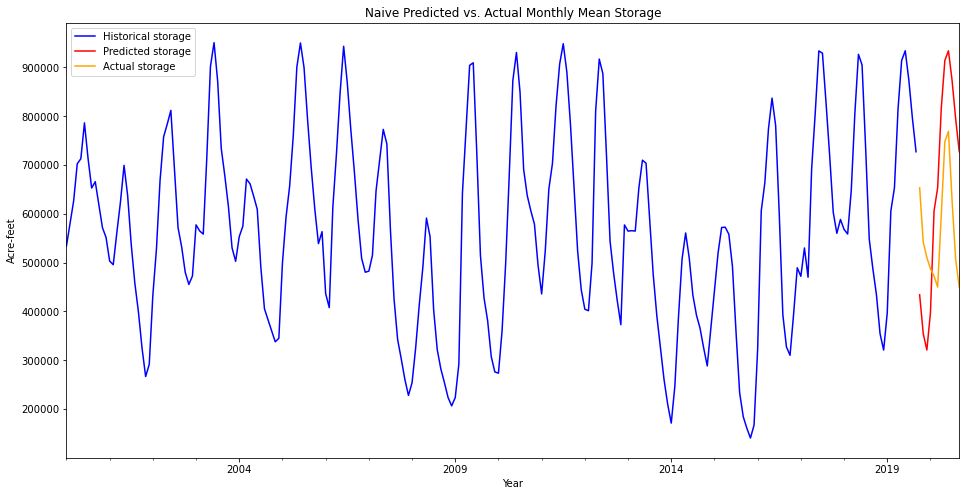

In [27]:
fig,ax = plt.subplots(figsize=(16,8))
train.storage['2000':].plot(ax=ax,color='blue',label = 'Historical storage')
pred_naive.storage.plot(ax=ax,color='red',label='Predicted storage')
test.storage.plot(ax=ax,color='orange',label='Actual storage')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Naive Predicted vs. Actual Monthly Mean Storage')
plt.show();

From above, we can see the discrepency between predicted(red) and actual(orange). To formalize this, we can calculate RMSE and MAE to compare the improvement of models moving forwards.

In [28]:
rmse_naive = np.sqrt(mean_squared_error(pred_naive.storage,test.storage)).round(2) 
mae_naive = mean_absolute_error(pred_naive.storage,test.storage).round(2)
naive_cc = np.corrcoef(x=pred_naive.storage,y=test.storage)[0][1].round(4)
print('Naive model RMSE: ', rmse_naive, ' ; Naive model MAE', mae_naive, 
      ' ; Naive model Correlation Coefficient : ', naive_cc)

Naive model RMSE:  206099.11  ; Naive model MAE 198737.33  ; Naive model Correlation Coefficient :  0.4961


## SARIMA Model

In order to predict 12 months in advance, we can use lagged data in the SARIMA model. This model only uses past data of the storage levels, with a seasonal component. We use PMDArima's built in grid-search function to find the best paramaters for SARIMA. With the limitations, we find that a SARIMA model with p,d,q= (3,1,2) and P,D,Q= (0,1,1) is the strongest. We set the mode to 12 as the season is a year for monthly data, and limit the number of parameters to 10 in order to reduce computation time and overfitting.

### Training SARIMA

In [29]:
sarima_model = auto_arima(y_train,start_p=0,start_d=0,start_q=0,
          max_p=3,max_d=3,max_q=3, start_P=0,start_D=0,
          start_Q=0, max_P=3,max_D=3,
          max_Q=3, m=12, seasonal=True, max_order=10,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9489.865, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9433.512, Time=0.05 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=9416.998, Time=0.19 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=9387.777, Time=0.90 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=9482.613, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=9418.805, Time=0.76 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=9389.758, Time=2.62 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9484.056, Time=0.60 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=9483.826, Time=2.90 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=9394.531, Time=4.86 sec
 ARIMA(0,0,0)(3,0,3)

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,0,2)(3,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,0,2)(3,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,2)(3,0,2)[12] intercept   : AIC=9112.106, Time=5.72 sec
 ARIMA(0,0,2)(3,0,3)[12] intercept   : AIC=inf, Time=6.64 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=9018.560, Time=0.04 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=9013.591, Time=0.13 sec
 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=9010.406, Time=0.47 sec
 ARIMA(0,0,3)(0,0,3)[12] intercept   : AIC=9009.837, Time=1.64 sec
 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=9017.167, Time=0.29 sec
 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=9015.189, Time=0.50 sec
 ARIMA(0,0,3)(1,0,2)[12] intercept   : AIC=9012.170, Time=2.06 sec
 ARIMA(0,0,3)(1,0,3)[12] intercept   : AIC=9011.757, Time=4.93 sec
 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=9018.684, Time=1.77 sec
 ARIMA(0,0,3)(2,0,1)[12] intercept   : AIC=9011.696, Time=1.75 sec
 ARIMA(0,0,3)(2,0,2)[12] intercept   : AIC=9013.694, Time=2.33 sec
 ARIMA(0,0,3)(2,0,3)[12] intercept   : AIC=inf, Time=7.38 sec
 ARIMA(0,0,

 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=8693.816, Time=2.22 sec
 ARIMA(2,0,2)(2,0,3)[12] intercept   : AIC=inf, Time=7.51 sec


/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(3,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,0,2)(3,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(3,0,1)[12] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(2,0,2)(3,0,2)[12] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(2,0,2)(3,0,3)[12] intercept   : AIC=8671.154, Time=7.40 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=8725.107, Time=0.11 sec
 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=8708.457, Time=0.38 sec
 ARIMA(2,0,3)(0,0,2)[12] intercept   : AIC=8688.208, Time=1.16 sec
 ARIMA(2,0,3)(0,0,3)[12] intercept   : AIC=8683.159, Time=3.78 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=8699.482, Time=0.74 sec
 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=8681.735, Time=0.75 sec
 ARIMA(2,0,3)(1,0,2)[12] intercept   : AIC=8673.400, Time=2.25 sec
 ARIMA(2,0,3)(1,0,3)[12] intercept   : AIC=8674.368, Time=5.69 sec
 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=8672.106, Time=2.41 sec
 ARIMA(2,0,3)(2,0,1)[12] intercept   : AIC=8669.438, Time=2.64 sec
 ARIMA(2,0,3)(2,0,2)[12] intercept   : AIC=8669.924, Time=3.25 sec
 ARIMA(2,0,

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,1)(3,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,0,1)(3,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(3,0,1)[12] intercept   : AIC=inf, Time=7.56 sec
 ARIMA(3,0,1)(3,0,2)[12] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(3,0,1)(3,0,3)[12] intercept   : AIC=inf, Time=7.98 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=8723.097, Time=0.10 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=8708.747, Time=0.33 sec
 ARIMA(3,0,2)(0,0,2)[12] intercept   : AIC=8689.595, Time=1.04 sec
 ARIMA(3,0,2)(0,0,3)[12] intercept   : AIC=8684.786, Time=3.34 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=8697.155, Time=0.68 sec
 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=8692.314, Time=0.95 sec
 ARIMA(3,0,2)(1,0,2)[12] intercept   : AIC=8681.341, Time=2.94 sec
 ARIMA(3,0,2)(1,0,3)[12] intercept   : AIC=8681.309, Time=6.90 sec
 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=8677.914, Time=2.78 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=8679.683, Time=2.79 sec
 ARIMA(3,0,2)(2,0,3)[

In [35]:
sarima_model

ARIMA(order=(3, 0, 3), scoring_args={}, seasonal_order=(3, 0, 0, 12),
      suppress_warnings=True)

### Testing SARIMA

In [ ]:
#fit model

sarima_model = SARIMAX(endog= y_train,order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()

#forecast ahead 1 year
sarima_preds = sarima_model.get_forecast(steps=12)
print(sarima_preds.summary_frame())
sarima_preds.summary_frame().plot()
plt.show();

In [ ]:
sarima_model.aic

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(sarima_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('SARIMA Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [ ]:
rmse_sarima = np.sqrt(mean_squared_error(sarima_preds.summary_frame()['mean'],test.storage)).round(2) 
mae_sarima = mean_absolute_error(sarima_preds.summary_frame()['mean'],test.storage).round(2)
sarima_cc = np.corrcoef(x=sarima_preds.summary_frame()['mean'],y=test.storage)[0][1].round(4)

print('SARIMA model RMSE: ', rmse_sarima, ' ; SARIMA model MAE', mae_sarima,
     'SARIMA correlation coefficient',sarima_cc)

error_reduction = 1 - (mae_sarima/mae_naive)

print('Error reduced by: ', error_reduction,'%')

In [ ]:
np.mean(test.storage)

By the mean absolute error above, we can see a clear improvement of a SARIMA forecast, to the tune of reducing error by 72.5%. The relative movement of the prediction is much more similar to the actual as well, the correlation coefficient increased to .92 from .54.

## SARIMAX: Incorporating exogenous models

Our goal is to now see if incorporating the precipitation and evaporation data improves the prediction. We will first  run the gridsearched paramaters with exogenous variables, then we will gridsearch with the exogenous variables to see if the paramaters change. 

We have to set up our own model grid search as no library contains the functionality to compare time series models with exogenous paramaters. Below, I set up grid search functions and then run it to find the best paramaters.

### Modelling

I took inspiration from the papers I read on natural time series. I iterated through SARIMA, SARIMAX, and an HWES, finding the best parameters through AIC-scoring in order to prevent data leakage. 

### Testing

I then compared the performance of the models on the test set, using RMSE, CC, and NSE as parameters. Each has their own unique strength.

## First SARIMAX Model

I fit and test the p,d,q= (3,0,3) and P,D,Q= (3,0,0) with the exogenous variables below.

In [ ]:
#fit and train

sarimax1_model = SARIMAX(endog= y_train,exog=X_train, order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()

#predict 1 year
sarimax1_preds = sarimax1_model.get_forecast(steps=12,exog=X_test)
print(sarimax1_preds.summary_frame())
sarimax1_preds.summary_frame().plot()
plt.show();

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(sarimax1_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('SARIMAX Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [ ]:
rmse_sarimax1 = np.sqrt(mean_squared_error(sarimax1_preds.summary_frame()['mean'],test.storage)).round(2) 
mae_sarimax1 = mean_absolute_error(sarimax1_preds.summary_frame()['mean'],test.storage).round(2)
sarimax1_cc = np.corrcoef(x=sarimax1_preds.summary_frame()['mean'],y=test.storage)[0][1].round(4)

print('First SARIMAX model RMSE: ', rmse_sarimax1, ' ; First SARIMAX model MAE', mae_sarimax1,
     'First SARIMAX model CC:', sarimax1_cc)

error_reduction = 1 - (mae_sarimax1/mae_naive)

print('Error reduced by: ', error_reduction,'%')

Using the exogenous paramaters with the gridsearched SARIMA parameters is less accurate prediction than the MAE. The relative movement is also less similar, the correlation coefficient dropped to .78. This is visible in the graph above too, where the orange line's movement for the first couple months opposes the actual.

## Gridsearched SARIMAX

In [ ]:
#set up gridsearch

#pdq are the ARMA potential paramaters
p = d = q = range(0,4)

arma_param_options = list(itertools.product(p,d,q))
print(arma_param_options)


#creating pdq for the seasonal potential paramaters, 12 for the seasonal gap
seasonal_param_options = [(x[0],x[1],x[2],12) for x in arma_param_options]
seasonal_param_options

In [ ]:
#gridsearch function

iteration = 0

for pdq in arma_param_options:
    for PDQ in seasonal_param_options:
        sarimax_gs = SARIMAX(endog= y_train,exog=X_train, order=pdq,seasonal_order=PDQ,enforce_invertibility=False,initialization='approximate_diffuse').fit()
        aic = sarimax_gs.aic
        if iteration ==0:
            best_fit = [pdq,PDQ, aic]
            print(best_fit[2])
        elif best_fit[2] > aic:
            best_fit = [pdq,PDQ,aic]
            print(best_fit)
        iteration += 1

return (best_fit)


After running this non-parallelized grid search overnight, I was able to determine that the best set of paramaters is (p,d,q)=(2,0,1) and (P,D,Q,s)=(3,0,0,12). With more time for this project, I would've created my own stepwise gridsearch as it would've been a lot less computationally intensive.

In [ ]:
best_fit = [(2,0,1),(3,0,0,12),8766]

best_sarimax = SARIMAX(endog=y_train,exog=X_train,order = best_fit[0],seasonal_order=best_fit[1]).fit()
best_sarimax.summary()

### Testing the Grid-Searched SARIMAX

In [ ]:
#predict 1 year
best_sarimax_preds = best_sarimax.get_forecast(steps=12,exog=X_test)
print(best_sarimax_preds.summary_frame())
best_sarimax_preds.summary_frame().plot()
plt.show();

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(best_sarimax_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Grid-Searched SARIMAX Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [ ]:
rmse_sarimax_best = np.sqrt(mean_squared_error(best_sarimax_preds.summary_frame()['mean'],test.storage)).round(2) 
mae_sarimax_best = mean_absolute_error(best_sarimax_preds.summary_frame()['mean'],test.storage).round(2)
best_sarimax_cc = np.corrcoef(x=best_sarimax_preds.summary_frame()['mean'],y=test.storage)[0][1].round(4)

print('Grid Searched SARIMAX model RMSE: ', rmse_sarimax_best, ' ; Grid Searched SARIMAX model MAE', mae_sarimax_best,
     'Grid Searched SARIMAX CC: ', best_sarimax_cc)

error_reduction = 1 - (mae_sarimax_best/mae_naive)

print('Error reduced by: ', error_reduction,'%')

Grid searching only reduced the error terms compared to the naive by 2%, and it decreased the relative similarity in movement, the CC dropped from .78 to .67. We can see this in the graph above given the discrepancies in slope between actual and prediction. The model with exogenous variables is still significantly weaker than the pure SARIMA model.

## Exponential Smoothing

Below, I demonstrate the importance of selecting models that do not implement trends, with seasonal, controlled data like a reservoir. Exponential Smoothing requires an increasing or decreasing trend in either the seasonal amplitude or the overall values. We can observe a clear issue in modelling, where the model goes into an impossible range, above the capacity of Folsom Lake. 

In [ ]:
hwes = HWES(endog=y_train,seasonal_periods=12,seasonal='add').fit()

hwes.summary()

In [ ]:
hwes_preds = hwes.forecast(12)
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(hwes_preds,color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('HWES Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [ ]:
rmse_hwes = np.sqrt(mean_squared_error(hwes_preds,test.storage)).round(2) 
mae_hwes = mean_absolute_error(hwes_preds,test.storage).round(2)
cc_hwes = np.corrcoef(x=hwes_preds,y=test.storage)[0][1].round(4)

print('Grid Searched SARIMAX model RMSE: ', rmse_hwes, ' ; Grid Searched SARIMAX model MAE', mae_hwes,
     'Grid Searched SARIMAX CC: ', cc_hwes)

error_reduction = 1 - (mae_sarimax_best/mae_naive)

print('Error reduced by: ', error_reduction,'%')

## Model Comparison

The best model was clearly the SARIMA model. It had the lowest errors and the highest correlation, meaning it tracked the most with the actual ebb and flow of the reservoir. Overall, the MAE was reduced by 78% compared to a naive model, the mean error was within an average of 9.5% of the actual value, and the correlation coefficent was high, .92, meaning that it matched 92% of the ebb and flow of the reservoir.

## Future Prediction: The 2021 season

To ensure accuracy, I wanted to test the model on Folsom Lake in a challenging year, the 2021 water year. As the drought has intensified, the water level has dipped to a 5 year low. We see below how the fitted paramters handle:

# Expanding the Model to Other Dams in California

Now that we have found that SARIMA is clearly the strongest on predicting reservoir storage, we will expand it out to other major California dams to see if it performs as well. Exogenous variables with a 1 year time delay have proven to be imperfect at reservoir prediction. I predicted that given the similarities in water requirements for agriculture and the similarity in the rain season.

To recap, we will only be using the endogenous y_train and y_test.

## Data Preparation

We will load and prepare the lake storage datasets from the RISE query website with the following function:

In [53]:
def data_prep(df):
    #drop unneeded cols
    drop_list = ['Location','Parameter','Timestep','Units','Aggregation']
    df.drop(drop_list, axis=1,inplace=True)
    df.rename(columns= {'Result': 'storage'},inplace=True)
    #set index to datetime
    df['date']= pd.to_datetime(df['Datetime (UTC)']).dt.date
    df.drop('Datetime (UTC)',axis=1,inplace=True)
    df.set_index('date',inplace=True)
    df.index = pd.to_datetime(df.index)
    
    #group up monthly
    df = df.resample('1M').mean().round(2)
    return(df)

#get name for plots
def get_lake_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [74]:
#load all the lakes

oroville = pd.read_excel('data/otherlakes/lakeoroville.xlsx',header=7)
trinity = pd.read_csv('data/otherlakes/trinitylake.csv', header= 7)
newmelones = pd.read_csv('data/otherlakes/newmelones.csv', header= 7)
millerton = pd.read_csv('data/otherlakes/millertonlake.csv', header= 7)
berryessa = pd.read_csv('data/otherlakes/shastalake.csv', header= 7)
shasta = pd.read_csv('data/otherlakes/lakeberryessa.csv', header= 7)

print(oroville.head())
rise_lake_dfs = [trinity,newmelones,millerton,berryessa,shasta]
cdec_lake_dfs = [oroville]
for lake in lake_dfs:
    lake = data_prep(lake)

# convert oroville data taf to af
    
print(oroville.head())


   ORO  D  15  STORAGE  Unnamed: 4  19891007  2,128,437 Unnamed: 7  AF
0  ORO  D  15  STORAGE         NaN  19891008  2,132,305        NaN  AF
1  ORO  D  15  STORAGE         NaN  19891009  2,126,006        NaN  AF
2  ORO  D  15  STORAGE         NaN  19891010  2,126,000        NaN  AF
3  ORO  D  15  STORAGE         NaN  19891011  2,118,948        NaN  AF
4  ORO  D  15  STORAGE         NaN  19891012  2,112,675        NaN  AF


KeyError: "['Location' 'Parameter' 'Timestep' 'Units' 'Aggregation'] not found in axis"

## Exploratory Data Analysis

A quick cycle through of all the lakes to see if they also function seasonally like Lake Folsom.

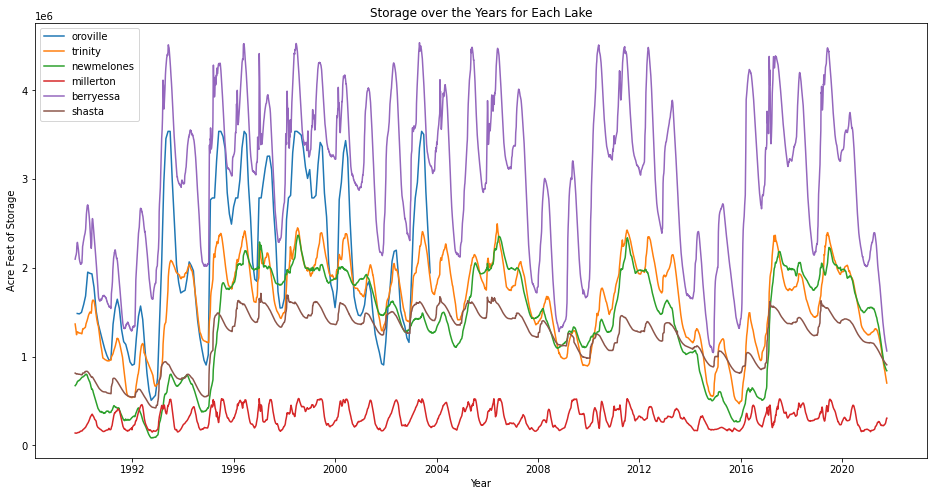

In [72]:
fig, ax = plt.subplots(figsize=(16,8))

for lake in lake_dfs:
    ax.plot(lake.storage, label = get_lake_name(lake))
    
    
plt.title('Storage over the Years for Each Lake')
plt.xlabel('Year')
plt.ylabel('Acre Feet of Storage')
plt.legend()
plt.show();

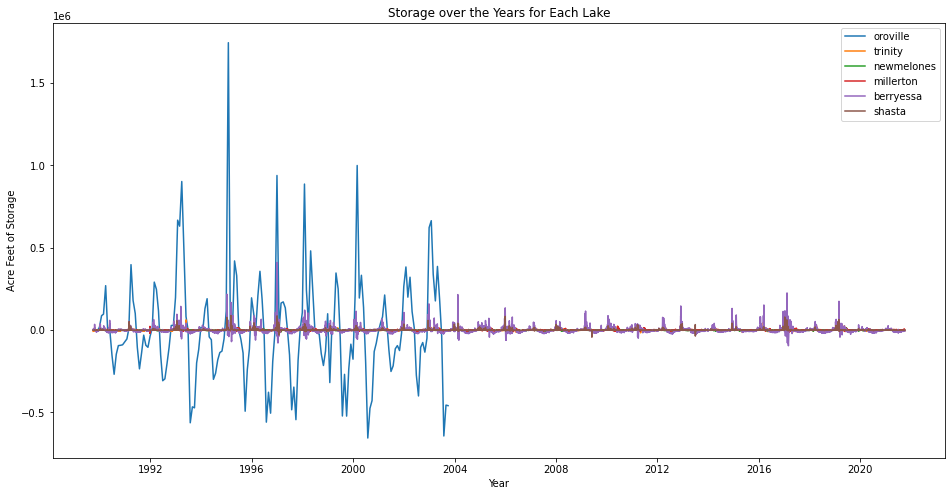

In [73]:
fig, ax = plt.subplots(figsize=(16,8))

for lake in lake_dfs:
    series = lake.squeeze()
    ax.plot(series.diff(), label = get_lake_name(lake))
    
    
plt.title('Storage over the Years for Each Lake')
plt.xlabel('Year')
plt.ylabel('Acre Feet of Storage')
plt.legend()
plt.show();

## Model Preparation
We can automate the process of examining all these by creating functions to build the train and test sets for each, gridsearch a SARIMA fit, and then test these.

In [ ]:
def lake_train_test_split(lake):
    len_df = len(lake.storage)
    train = lake[:len_df-12]
    test = lake[len_df-12:len_df]
    return(train,test)

def best_fit_sarima(train):
    model = SARIMAX(endog= train,order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()
    init_aic = model.aic
    
    gs_model = auto_arima(train,start_p=0,start_d=0,start_q=0,
          max_p=3,max_d=3,max_q=3, start_P=0,start_D=0,
          start_Q=0, max_P=3,max_D=3,
          max_Q=3, m=12, seasonal=True, max_order=10,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20)
    
    if gs_model.aic() > init_aic:
        return(gs_model)
    elif init_aic > gs_model.aic():
        return(model)

## Northern Sierra / Sacramento Watershed Reservoirs

### Lake Oroville

Lake Oroville, located in the foothills below the Northern Sierras, is the second largest reservoir in California and is a key water supply for billions for dollar of agriculture and millions of residents. Oroville is unique in our data in that there is only data from a special consultation which ended in 2003. So our trainset will run from the 1990 to 2002 water seasons. The data is also already aggregated up monthly.

In [51]:
# import csv

oroville = pd.read_csv('data/otherlakes/lakeoroville.csv',header=9)

print(oroville.info())
#edit and prepare for time series analysis
drop_list = ['Location','Parameter','Timestep','Units','Aggregation']

oroville.drop(drop_list, axis=1,inplace=True)
oroville.rename(columns= {'Result': 'storage'},inplace=True)
oroville['date']= pd.to_datetime(oroville['Datetime (UTC)']).dt.date
oroville.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
oroville.set_index('date',inplace=True)
oroville.index = pd.to_datetime(oroville.index)

oroville.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        168 non-null    object 
 1   Parameter       168 non-null    object 
 2   Result          168 non-null    float64
 3   Units           168 non-null    object 
 4   Timestep        168 non-null    object 
 5   Aggregation     168 non-null    object 
 6   Datetime (UTC)  168 non-null    object 
dtypes: float64(1), object(6)
memory usage: 9.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1989-10-31 to 2003-09-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   storage  168 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


Below, from a cursory glance, we can see that this lake is a standard California reservoir in its seasonality: water storage increases and peaks from the spring snow melt and is at its lowest in October and November before the winter rains start.

In [ ]:
oroville.storage.plot()
plt.title('Water Storage Over Time')
plt.show();

In [ ]:
#20 years of data to train
train_start, train_stop = '1990-10-01','2002-10-01'

#1 year for testing
test_start, test_stop = '2002-10-01', '2003-10-01'

#create train and 
ov_train, ov_test = oroville[train_start:train_stop], oroville[test_start:test_stop]

print(ov_test)


### Oroville with Folsom Grid-Searched Paramaters
Below, we test Oroville's performance in the 2003 water year with the order (3,0,3) and seasonal_order (3,0,0,12) that proved to be the best fit for Folsom.

In [ ]:
ov_model = SARIMAX(endog= ov_train,order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()


ov_preds = ov_model.get_forecast(steps=12)


fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ov_train, color = 'blue',label= 'Historical storage')
ax.plot(ov_test.storage,color='black',label= 'Actual 2003 WY storage')
ax.plot(ov_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2003 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Grid-Searched SARIMA Predicted vs. Actual Monthly Mean Storage at Lake Oroville')
plt.show();

### Orvoille Grid Search
To see if it is similar in prediction methodology to Folsom Lake, we are going to run a cross validated gridsearch to find the best SARIMA parameters. The data is not necessarily stationarry, so its possible there will be a less solid fit.

In [ ]:
sarima_model = auto_arima(ov_train,start_p=0,start_d=0,start_q=0,
          max_p=3,max_d=3,max_q=3, start_P=0,start_D=0,
          start_Q=0, max_P=3,max_D=3,
          max_Q=3, m=12, seasonal=True, max_order=10,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20)

In [ ]:
ov_model = SARIMAX(endog= ov_train,order=(2,1,3),seasonal_order=(0,0,1,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()


ov_preds = ov_model.get_forecast(steps=12)


fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ov_train, color = 'blue',label= 'Historical storage')
ax.plot(ov_test.storage,color='black',label= 'Actual 2003 WY storage')
ax.plot(ov_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2003 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Grid-Searched SARIMA Predicted vs. Actual Monthly Mean Storage at Lake Oroville')
plt.show();

Looking at both graphs, Folsom Lake's paramaters nor grid-searched SARIMA model were unsuccessful at predicting the boon of a year that 2003 was for Lake Oroville. However, the model was still strong at capturing the seasonal movements of the reservoir.

### Trinity Lake

In [ ]:
trinity = pd.read_csv('data/otherlakes/trinitylake.csv', header= 7)

drop_list = ['Location','Parameter','Timestep','Units','Aggregation']

trinity.drop(drop_list, axis=1,inplace=True)
trinity.rename(columns= {'Result': 'storage'},inplace=True)
trinity['date']= pd.to_datetime(trinity['Datetime (UTC)']).dt.date
trinity.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
trinity.set_index('date',inplace=True)
trinity.index = pd.to_datetime(trinity.index)

trinity.info()

In [ ]:
trinity = trinity.resample('1M').mean().round(2)

trinity.plot()
plt.show();

### Lake Berryessa

In [ ]:
berryessa = pd.read_csv('data/otherlakes/lakeberryessa.csv', header= 7)

drop_list = ['Location','Parameter','Timestep','Units','Aggregation']

berryessa.drop(drop_list, axis=1,inplace=True)
berryessa.rename(columns= {'Result': 'storage'},inplace=True)
berryessa['date']= pd.to_datetime(berryessa['Datetime (UTC)']).dt.date
berryessa.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
berryessa.set_index('date',inplace=True)
berryessa.index = pd.to_datetime(berryessa.index)

berryessa.info()

In [ ]:
#group up to monthly data

### Shasta Lake

In [ ]:
shasta = pd.read_csv('data/otherlakes/shastalake.csv', header= 7)

drop_list = ['Location','Parameter','Timestep','Units','Aggregation']

shasta.drop(drop_list, axis=1,inplace=True)
shasta.rename(columns= {'Result': 'storage'},inplace=True)
shasta['date']= pd.to_datetime(shasta['Datetime (UTC)']).dt.date
shasta.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
shasta.set_index('date',inplace=True)
shasta.index = pd.to_datetime(shasta.index)

shasta.info()

In [ ]:
#group up to monthly data

## San Joaquin Watershed Reservoirs


### Don Pedro

### Exchequer

### New Melones

In [ ]:
newmelones = pd.read_csv('data/otherlakes/newmelones.csv', header= 7)

drop_list = ['Location','Parameter','Timestep','Units','Aggregation']

newmelones.drop(drop_list, axis=1,inplace=True)
newmelones.rename(columns= {'Result': 'storage'},inplace=True)
newmelones['date']= pd.to_datetime(newmelones['Datetime (UTC)']).dt.date
newmelones.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
newmelones.set_index('date',inplace=True)
newmelones.index = pd.to_datetime(newmelones.index)

newmelones.info()

### Pine Flat

### Millerton

In [ ]:
millerton = pd.read_csv('data/otherlakes/millertonlake.csv', header= 7)

drop_list = ['Location','Parameter','Timestep','Units','Aggregation']

millerton.drop(drop_list, axis=1,inplace=True)
millerton.rename(columns= {'Result': 'storage'},inplace=True)
millerton['date']= pd.to_datetime(millerton['Datetime (UTC)']).dt.date
millerton.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
millerton.set_index('date',inplace=True)
millerton.index = pd.to_datetime(millerton.index)

millerton.info()

# Recommendations

# Future Work

# References

1. https://escholarship.org/uc/item/6hq949t6
2. https://data.usbr.gov/time-series/search?v=1
3. https://www.usgs.gov/special-topic/water-science-school/science/droughts-things-know?qt-science_center_objects=0#qt-science_center_objects
4. https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0
5. https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
6. https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/